# Notebook exploring the idea of hierarchical summarization

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import timedelta

import sys
sys.path.insert(0, "/Users/connorparish/code/hindsight")

from hindsight_server.db import HindsightDB
from hindsight_server.utils import add_datetimes, add_usage_ids

In [2]:
db = HindsightDB()

In [3]:
frames = db.get_frames()

In [4]:
frames.loc[frames['id'] == 344695].iloc[0]['path']

'/Users/connorparish/.hindsight_server/data/raw_screenshots/2024/08/30/com-espn-fantasy-lm-football/com-espn-fantasy-lm-football_1724979751204.jpg'

In [5]:
frames = add_datetimes(frames)
frames = add_usage_ids(frames)

In [6]:
usage_df = frames.groupby('usage_id')['datetime_local'].agg([min, max])
usage_df['duration'] = usage_df['max'] - usage_df['min']
usage_df['day'] = usage_df['min'].dt.floor('D')

/var/folders/c_/2c9vmfhd35bgwc_6h0q80d180000gn/T/ipykernel_47072/921806613.py:1: FutureWarning: The provided callable <built-in function min> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  usage_df = frames.groupby('usage_id')['datetime_local'].agg([min, max])
/var/folders/c_/2c9vmfhd35bgwc_6h0q80d180000gn/T/ipykernel_47072/921806613.py:1: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  usage_df = frames.groupby('usage_id')['datetime_local'].agg([min, max])


In [7]:
usage_df.duration.sum()

Timedelta('19 days 09:40:51.679001643')

# Total time

In [8]:
usage_df['hour'] = usage_df['min'].dt.hour
usage_df['duration_minutes'] = usage_df['duration'].apply(lambda x: x.total_seconds() // 60)

In [9]:
heatmap_data = usage_df.groupby(['day', 'hour'])['duration_minutes'].sum().unstack().fillna(0)

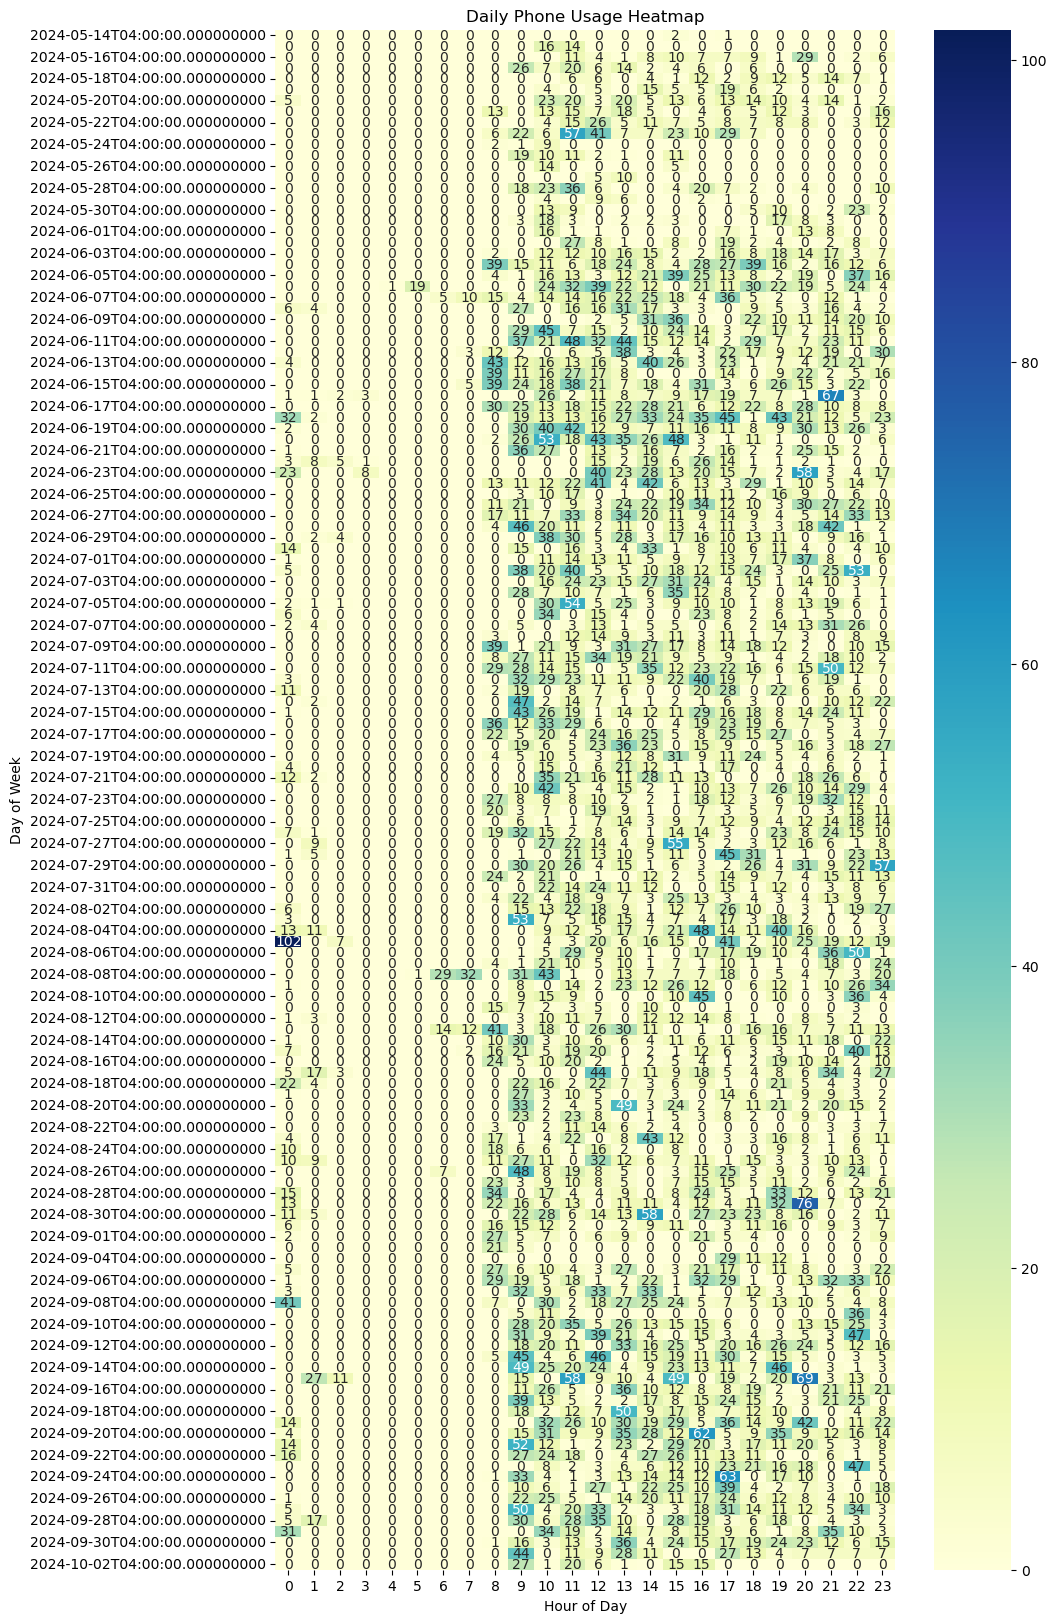

In [10]:
plt.figure(figsize=(10, 20))
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", fmt="g")
plt.title('Daily Phone Usage Heatmap')
plt.ylabel('Day of Week')
plt.xlabel('Hour of Day')
plt.show()

# Number of usages per hour

In [11]:
heatmap_data = usage_df.groupby(['day', 'hour'])['min'].count().unstack().fillna(0)

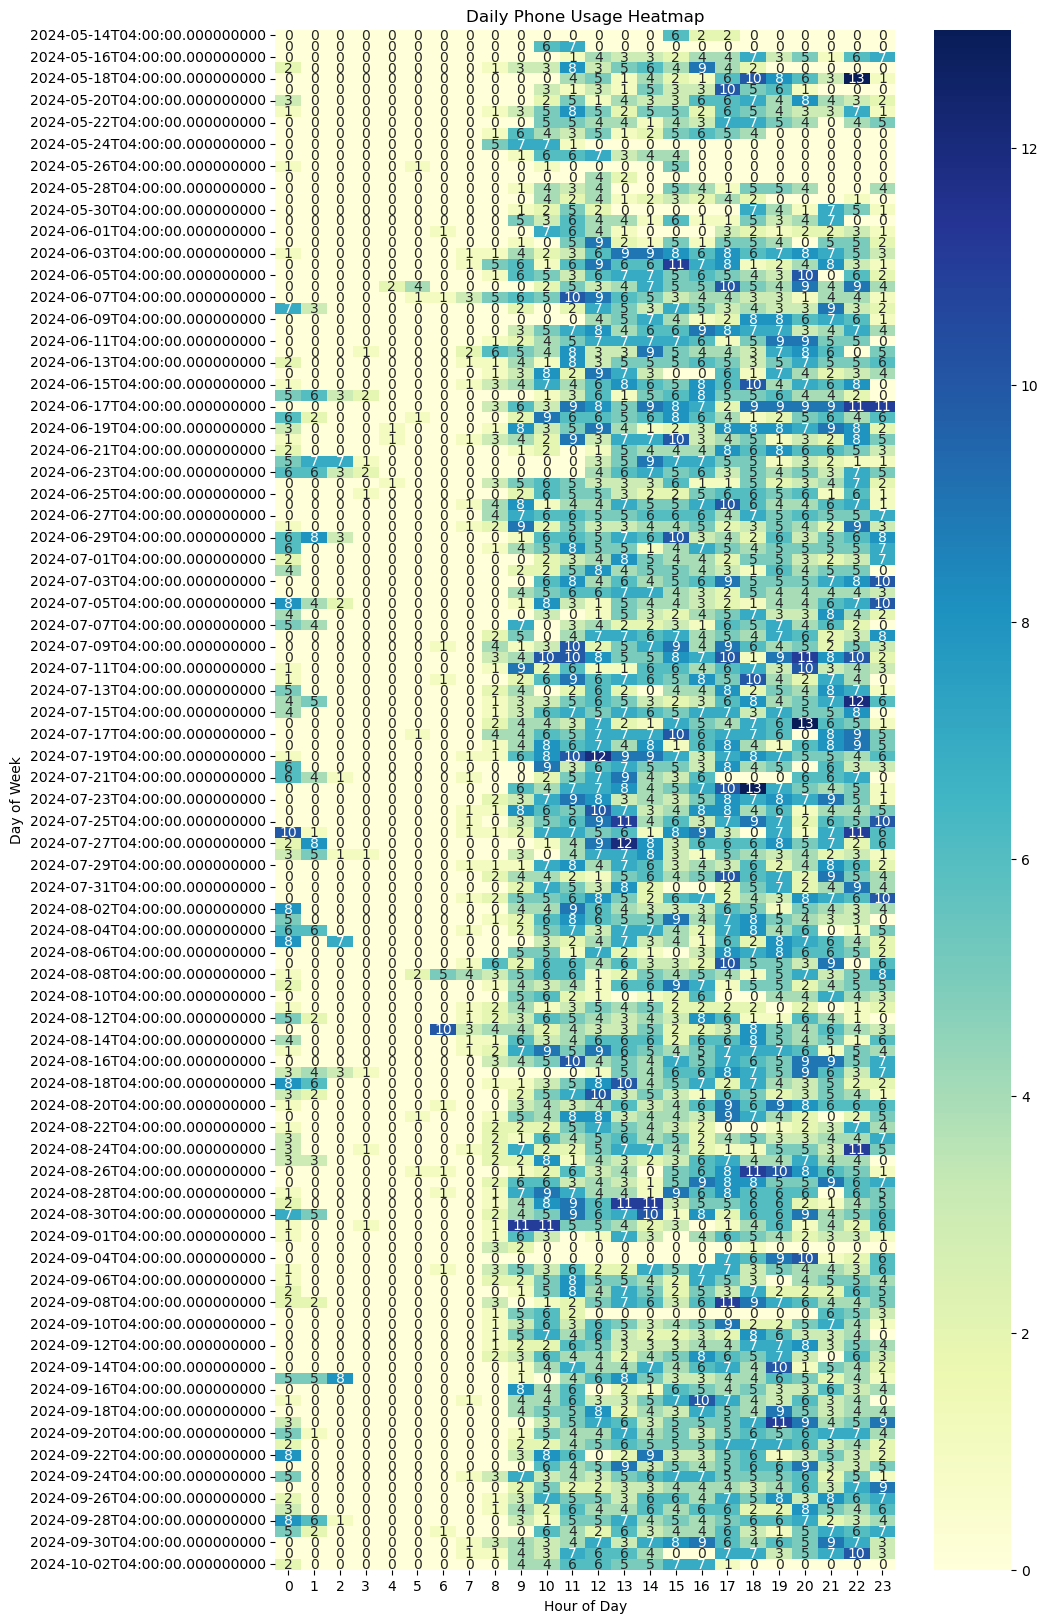

In [12]:
plt.figure(figsize=(10, 20))
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", fmt="g")
plt.title('Daily Phone Usage Heatmap')
plt.ylabel('Day of Week')
plt.xlabel('Hour of Day')
plt.show()

In [13]:
usage_df.sort_values(by="duration")

,min,max,duration,day,hour,duration_minutes
usage_id,,,,,,
3752,2024-07-11 17:58:14.032000065-04:00,2024-07-11 17:58:14.032000065-04:00,0 days 00:00:00,2024-07-11 00:00:00-04:00,17,0.0
3727,2024-07-11 11:30:34.561000109-04:00,2024-07-11 11:30:34.561000109-04:00,0 days 00:00:00,2024-07-11 00:00:00-04:00,11,0.0
4108,2024-07-16 09:48:10.983999968-04:00,2024-07-16 09:48:10.983999968-04:00,0 days 00:00:00,2024-07-16 00:00:00-04:00,9,0.0
9084,2024-09-22 20:33:22.058000088-04:00,2024-09-22 20:33:22.058000088-04:00,0 days 00:00:00,2024-09-22 00:00:00-04:00,20,0.0
2257,2024-06-21 18:54:09.585000038-04:00,2024-06-21 18:54:09.585000038-04:00,0 days 00:00:00,2024-06-21 00:00:00-04:00,18,0.0
...,...,...,...,...,...,...
8960,2024-09-21 09:37:05.535000086-04:00,2024-09-21 10:30:01.898999929-04:00,0 days 00:52:56.363999843,2024-09-21 00:00:00-04:00,9,52.0
426,2024-05-23 11:29:03.882999897-04:00,2024-05-23 12:22:36.714999914-04:00,0 days 00:53:32.832000017,2024-05-23 00:00:00-04:00,11,53.0
8916,2024-09-20 16:29:48.257999896-04:00,2024-09-20 17:26:03.911000013-04:00,0 days 00:56:15.653000117,2024-09-20 00:00:00-04:00,16,56.0


# See how long I looked at something

In [21]:
frames['time_difference_prev'] = frames['time_difference'].shift(-1)
within_usage = frames.loc[frames['time_difference_prev'] < timedelta(seconds=120)].reset_index()

In [22]:
within_usage = within_usage.loc[within_usage['application'] == "Twitter"]

In [27]:
looked_at = within_usage.loc[(within_usage['time_difference_prev'] > timedelta(seconds=3)) & 
                 (within_usage['time_difference_prev'] < timedelta(seconds=12))]
looked_at.to_csv("looked_at_tweets.csv", index=False)

In [26]:
looked_at.iloc[0]['path']

'/Users/connorparish/.hindsight_server/data/raw_screenshots/2024/05/20/com-twitter-android/com-twitter-android_1716233973168.jpg'

In [24]:
len(looked_at)

4402

In [82]:
within_usage.sort_values(by="time_difference_prev", ascending=False)

,index,id,timestamp,path,application,chromadb_processed,application_org,datetime_utc,datetime_local,time_difference,usage_id,time_difference_prev
78863,80864,105268,1718731845197,/Users/connorparish/.hindsight_server/data/raw...,Twitter,1,com-twitter-android,2024-06-18 17:30:45.197000027+00:00,2024-06-18 13:30:45.197000027-04:00,0 days 00:00:16.101999998,2001,0 days 00:01:24.187999963
273855,279354,303759,1723938951783,/Users/connorparish/.hindsight_server/data/raw...,Twitter,1,com-twitter-android,2024-08-17 23:55:51.782999992+00:00,2024-08-17 19:55:51.782999992-04:00,0 days 00:00:06.213000059,6668,0 days 00:01:22.489000082
148779,152446,176850,1720583364492,/Users/connorparish/.hindsight_server/data/raw...,Twitter,1,com-twitter-android,2024-07-10 03:49:24.492000103+00:00,2024-07-09 23:49:24.492000103-04:00,0 days 00:00:02.065000057,3598,0 days 00:01:20.389999866
382660,391012,415417,1726680931170,/Users/connorparish/.hindsight_server/data/raw...,Twitter,1,com-twitter-android,2024-09-18 17:35:31.170000076+00:00,2024-09-18 13:35:31.170000076-04:00,0 days 00:00:02.087000131,8741,0 days 00:01:18.253000021
166795,170608,195012,1721073316497,/Users/connorparish/.hindsight_server/data/raw...,Twitter,1,com-twitter-android,2024-07-15 19:55:16.496999979+00:00,2024-07-15 15:55:16.496999979-04:00,0 days 00:00:02.108999968,4061,0 days 00:01:07.223000050
...,...,...,...,...,...,...,...,...,...,...,...,...
41034,40234,64638,1717787938172,/Users/connorparish/.hindsight_server/data/raw...,Twitter,1,com-twitter-android,2024-06-07 19:18:58.171999931+00:00,2024-06-07 15:18:58.171999931-04:00,0 days 00:00:02.116999864,1142,0 days 00:00:02.026999951
112889,115779,140183,1719543898625,/Users/connorparish/.hindsight_server/data/raw...,Twitter,1,com-twitter-android,2024-06-28 03:04:58.625000+00:00,2024-06-27 23:04:58.625000-04:00,0 days 00:00:02.092000008,2721,0 days 00:00:02.026999950
45058,46326,70730,1717956545495,/Users/connorparish/.hindsight_server/data/raw...,Twitter,1,com-twitter-android,2024-06-09 18:09:05.494999886+00:00,2024-06-09 14:09:05.494999886-04:00,0 days 00:00:02.093999863,1247,0 days 00:00:02.025000095
68144,70000,94404,1718476432459,/Users/connorparish/.hindsight_server/data/raw...,Twitter,1,com-twitter-android,2024-06-15 18:33:52.459000111+00:00,2024-06-15 14:33:52.459000111-04:00,0 days 00:00:02.114000082,1719,0 days 00:00:02.024999857


In [84]:
within_usage.sort_values(by="time_difference_prev", ascending=False).iloc[12]['path']

'/Users/connorparish/.hindsight_server/data/raw_screenshots/2024/08/13/com-twitter-android/com-twitter-android_1723567176539.jpg'

In [85]:
within_usage.sort_values(by="time_difference_prev", ascending=False).iloc[12]

index                                                              267506
id                                                                 291911
timestamp                                                   1723567176539
path                    /Users/connorparish/.hindsight_server/data/raw...
application                                                       Twitter
chromadb_processed                                                      1
application_org                                       com-twitter-android
datetime_utc                          2024-08-13 16:39:36.539000034+00:00
datetime_local                        2024-08-13 12:39:36.539000034-04:00
time_difference                                 0 days 00:00:08.107000112
usage_id                                                             6304
time_difference_prev                            0 days 00:00:36.161000014
Name: 258828, dtype: object

In [35]:
udf = frames.loc[frames['usage_id'] == 5764]

In [36]:
set(udf['application'])

{'Maps',
 'Spotify',
 'com-android-systemui',
 'com-google-android-apps-nexuslauncher',
 'com-google-android-projection-gearhead'}

In [42]:
udf.loc[udf['application'] == 'Maps'].iloc[3]['path']

'/Users/connorparish/.hindsight_server/data/raw_screenshots/2024/08/05/com-google-android-apps-maps/com-google-android-apps-maps_1722837817515.jpg'

In [34]:
frames.loc[frames['id'] == 263004].iloc[0]['path']

'/Users/connorparish/.hindsight_server/data/raw_screenshots/2024/08/05/com-google-android-apps-maps/com-google-android-apps-maps_1722837970149.jpg'